## Part 2:  搭建一个简单的问答系统

本次项目的目标是搭建一个基于检索式的简单的问答系统。至于什么是检索式的问答系统请参考课程直播内容/PPT介绍。 

通过此项目，你将会有机会掌握以下几个知识点：
1. 字符串操作   2. 文本预处理技术（词过滤，标准化）   3. 文本的表示（tf-idf, word2vec)  4. 文本相似度计算  5. 文本高效检索

此项目需要的数据：
1. dev-v2.0.json: 这个数据包含了问题和答案的pair， 但是以JSON格式存在，需要编写parser来提取出里面的问题和答案。 
2. glove.6B: 这个文件需要从网上下载，下载地址为：https://nlp.stanford.edu/projects/glove/， 请使用d=100的词向量

##### 检索式的问答系统
问答系统所需要的数据已经提供，对于每一个问题都可以找得到相应的答案，所以可以理解为每一个样本数据是 <问题、答案>。 
那系统的核心是当用户输入一个问题的时候，首先要找到跟这个问题最相近的已经存储在库里的问题，然后直接返回相应的答案即可。 举一个简单的例子：

假设我们的库里面已有存在以下几个<问题,答案>：
<"贪心学院主要做什么方面的业务？”， “他们主要做人工智能方面的教育”>
<“国内有哪些做人工智能教育的公司？”， “贪心学院”>
<"人工智能和机器学习的关系什么？", "其实机器学习是人工智能的一个范畴，很多人工智能的应用要基于机器学习的技术">
<"人工智能最核心的语言是什么？"， ”Python“>
.....

假设一个用户往系统中输入了问题 “贪心学院是做什么的？”， 那这时候系统先去匹配最相近的“已经存在库里的”问题。 那在这里很显然是
 “贪心学院是做什么的”和“贪心学院主要做什么方面的业务？”是最相近的。 所以当我们定位到这个问题之后，直接返回它的答案 
 “他们主要做人工智能方面的教育”就可以了。 所以这里的核心问题可以归结为计算两个问句（query）之间的相似度。

在本次项目中，你会频繁地使用到sklearn这个机器学习库。具体安装请见：http://scikit-learn.org/stable/install.html  
sklearn包含了各类机器学习算法和数据处理工具，包括本项目需要使用的词袋模型，均可以在sklearn工具包中找得到。 
另外，本项目还需要用到分词工具jieba, 具体使用方法请见 https://github.com/fxsjy/jieba

### Part 2.1  第一部分： 读取文件，并把内容分别写到两个list里（一个list对应问题集，另一个list对应答案集）

In [1]:
def read_corpus():
    """
    读取给定的语料库，并把问题列表和答案列表分别写入到 qlist, alist 里面。 在此过程中，不用对字符换做任何的处理（这部分需要在 Part 2.3里处理）
    qlist = ["问题1"， “问题2”， “问题3” ....]
    alist = ["答案1", "答案2", "答案3" ....]
    务必要让每一个问题和答案对应起来（下标位置一致）
    """
    import json
    
    path = "./train-v2.0.json"
    with open(path,'r',encoding="utf8") as f:
        all_data = json.loads(f.read())
        # json.loads：将一编码的JSON字符串解码为Python对象
    data = all_data["data"]
    qlist = []
    alist = []
    
    for dic in data:
        paragraphs = dic["paragraphs"]
        for para in paragraphs:
            qas = para["qas"]
            for qa in qas:
                if qa["answers"]:
                    answer = qa["answers"][0]["text"]
                    alist.append(answer)
                    question = qa["question"]
                    qlist.append(question)
    assert len(qlist) == len(alist)  # 确保长度一样
    return qlist, alist

### Part 2.2 理解数据（可视化分析/统计信息）
对数据的理解是任何AI工作的第一步，需要充分对手上的数据有个更直观的理解。 

In [2]:

# TODO: 统计一下在qlist 总共出现了多少个单词？ 总共出现了多少个不同的单词？
#       这里需要做简单的分词，对于英文我们根据空格来分词即可，其他过滤暂不考虑（只需分词）
import string
import re

# 去标点符号，分词，得到词-词频字典
def segmentWords(lst):
    total = 0
    word_dict = {}
    for line in lst:
        # re.compile 函数用于编译正则表达式，生成一个正则表达式对象(pattern)
        pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        # 对于输入一个字符串，利用正则表达式（的强大的字符串处理功能），去实现（相对复杂的）字符串中的处理，然后返回被替换后的字符串
        # 这一步是去除句子之间的空格
        sentence = pattern.sub('', line)
        # 利用空格进行分词
        words = sentence.split()
        for word in words:
            # 字典的get操作仅有一个参数时相当于dic['x'], 当有两个参数时，如果字典里取不到就返回后一个值
            word_dict[word] = word_dict.get(word, 0) + 1
            total += 1
    return total, word_dict

qlist, alist = read_corpus()
word_total, q_dict = segmentWords(qlist)
total_diff_word = len(q_dict.keys())
print("总共 %d 个单词" % word_total)
print('总共 %d 个不同的单词' % total_diff_word)

总共 873167 个单词
总共 45246 个不同的单词


In [3]:

# TODO: 统计一下qlist中每个单词出现的频率，并把这些频率排一下序，然后画成plot. 比如总共出现了总共7个不同单词，而且每个单词出现的频率为 4, 5,10,2, 1, 1,1
#       把频率排序之后就可以得到(从大到小) 10, 5, 4, 2, 1, 1, 1. 然后把这7个数plot即可（从大到小）
#       需要使用matplotlib里的plot函数。y轴是词频

import matplotlib.pyplot as plt

# dic.items操作以元组的形式返回字典的键值对
# sort函数只能应用在list对象上，而sorted可以对所有可迭代对象使用，并返回一个新的list，key是排序对象，reverse的True是降序
word_sorted = sorted(q_dict.items(), key=lambda k:k[1], reverse=True) # 按词频排序
word_freq = []
word_list = []
for line in word_sorted:
    word_list.append(line[0])
    word_freq.append(line[1])

print(word_freq[:100])
print(word_list[:100])

x = range(total_diff_word)
plt.plot(x, word_freq, 'ro')
plt.ylabel('word frequency')
plt.show()

temp = [n for n in word_freq if n <= 50]
plt.plot(range(len(temp)), temp, color='r', linestyle='-', linewidth=2)
plt.ylabel('word frequency')
plt.show()

[61008, 37007, 33994, 21807, 18451, 17067, 16201, 15635, 13241, 10778, 8025, 8024, 7229, 7209, 5498, 5457, 5368, 4441, 4430, 4331, 4296, 4189, 4137, 4109, 3711, 3665, 3660, 3369, 3241, 3145, 3016, 2972, 2941, 2709, 2636, 2284, 2276, 2165, 2119, 2103, 1924, 1703, 1644, 1561, 1485, 1476, 1420, 1337, 1310, 1301, 1294, 1291, 1283, 1264, 1250, 1248, 1227, 1224, 1191, 1183, 1166, 1158, 1095, 1081, 1062, 1042, 1015, 1008, 982, 974, 930, 921, 919, 913, 911, 910, 895, 883, 876, 872, 855, 847, 840, 824, 819, 810, 808, 805, 787, 778, 775, 760, 744, 722, 717, 713, 702, 690, 683, 660]
['the', 'What', 'of', 'in', 'to', 'was', 'is', 'did', 'what', 'a', 'How', 'Who', 'and', 'for', 'many', 'are', 'When', 'that', 'were', 'does', 'In', 'on', 'with', 'Which', 'from', 'by', 'as', 'year', 'Where', 'The', 'be', 'have', 'do', 'first', 'name', 'which', 'an', 'at', 'type', 'used', 'has', 'most', 'can', 'people', 'their', 'other', 'how', 'his', 'it', 'called', 'two', 'when', 'its', 'during', 'one', 'much', 'afte

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [4]:
# TODO: 在qlist和alist里出现次数最多的TOP 10单词分别是什么？
a_total, a_dic = segmentWords(alist)
words_sorted = sorted(a_dic.items(),key=lambda k:k[1],reverse=True)
word_freq2 = []
word_list2 = []
for line in words_sorted:
    word_list2.append(line[0])
    word_freq2.append(line[1])
print("top 10 word of qlist are: ", word_list[:10])
print("top 10 word of alist are: ", word_list2[:10])

top 10 word of qlist are:  ['the', 'What', 'of', 'in', 'to', 'was', 'is', 'did', 'what', 'a']
top 10 word of alist are:  ['the', 'of', 'and', 'to', 'a', 'in', 'The', 'or', 'for', 'million']


### 2.3 文本预处理
此部分需要尝试做文本的处理。在这里我们面对的是英文文本，所以任何对英文适合的技术都可以考虑进来。

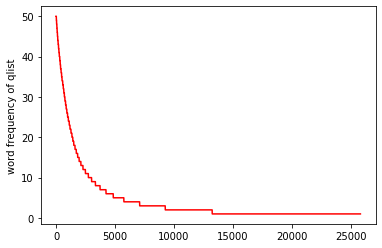

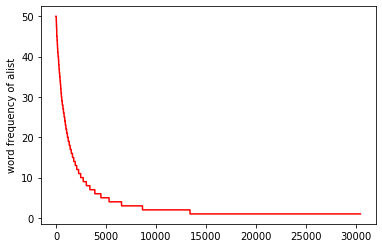

the length of new qlist is  86821
the length of new alist is  86821


In [5]:
# TODO: 对于qlist, alist做文本预处理操作。 可以考虑以下几种操作：
#       1. 停用词过滤 （去网上搜一下 "english stop words list"，会出现很多包含停用词库的网页）   
#       2. 转换成lower_case： 这是一个基本的操作   
#       3. 去掉一些无用的符号： 比如连续的感叹号！！！， 或者一些奇怪的单词。
#       4. 去掉出现频率很低的词：比如出现次数少于10,20....
#       5. 对于数字的处理： 分词完只有有些单词可能就是数字比如44，415，把所有这些数字都看成是一个单词，这个新的单词我们可以定义为 "#number"
#       6. stemming（利用porter stemming): 因为是英文，所以stemming也是可以做的工作
#       7. 其他（如果有的话）
#       请注意，不一定要按照上面的顺序来处理，具体处理的顺序思考一下，然后选择一个合理的顺序

import nltk
# 从nltk的语料库中导入停用词库
from nltk.corpus import stopwords

# 使用nltk中的词干提取功能
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

stopwords = set(stopwords.words('english'))

# 预处理：去标点符号，去停用词，stemming，将数字转换为'#number'表示
def preprocessing(lst):
    new_list = []
    word_dic = {}
    for line in lst:
        # 统计所有的标点符号很困难，考虑用string.punctuation来提取出所有的标点符号
        # re.escape是对所有的需要转义的字符进行操作，可以避免写一堆的反斜杠
        pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        sentence = pattern.sub("", line)
        # 都转化成小写
        sentence = sentence.lower()
        # 进行分词
        words = sentence.split()
        temp = []
        for word in words:
            if word not in stopwords:
                # 去除文本里的数字, 如果是数字则换成#number, 如果不是数字就不变
                word = '#number' if word.isdigit() else word
                # 进行词干提取
                w = stemmer.stem(word)
                word_dic[w] = word_dic.get(w, 0) + 1
                temp.append(w)
        new_list.append(temp)
    return  word_dic, new_list
    
# 画出100类的词频统计图
def drawgraph(dic, name):
    # python字典的dic.values以列表的形式返回值
    freq = list(dic.values())
    # reverse=True表示降序排列
    freq.sort(reverse=True)
    temp = [n for n in freq if n <=50]
    plt.plot(range(len(temp)), temp, 'r-')
    plt.ylabel(name)
    plt.show()
    
# 过滤掉词频低于2， 大于10000的词
def filterword(dic, lst, bottom, top):
    temp =[]
    # 再次强调，dic.items返回的是字典的键值对
    for k, v in dic.items():
        if bottom <= v <= top:
            temp.append(k)
    new_list = []
    for line in lst:
        words = [w for w in line if w in temp]
        new_list.append(' '.join(words))
    
    return new_list
        


q_dict,q_list = preprocessing(qlist)
drawgraph(q_dict,"word frequency of qlist")

a_dict,a_list = preprocessing(alist)
drawgraph(a_dict, "word frequency of alist")
 
new_qlist = filterword(q_dict, q_list, 2, 10000)
new_alist = filterword(a_dict, a_list, 2, 10000)
print("the length of new qlist is ",len(new_qlist))
print("the length of new alist is ",len(new_alist))


### 2.4 文本表示
在上面的步骤中，删除了出现次数小于2和大于100000的词，原因是这两个位置词频断档比较严重
当我们做完关键的预处理过程之后，就需要把每一个文本转换成向量。

In [6]:
# TODO: 把qlist中的每一个问题字符串转换成tf-idf向量, 转换之后的结果存储在X矩阵里。 X的大小是： N * D的矩阵。 这里N是问题的个数（样本个数），
#       D是字典库的大小。

from sklearn.feature_extraction.text import TfidfVectorizer
# 使用sklearn的特征工程中的Tf-idf实现对文本特征进行数值化的操作，API：sklearn.feature_extraction
# 创建一个tf-idf的vectorizer，实例化
vectorizer = TfidfVectorizer()
# 把结果放在x矩阵里
# fit_transform：其实是两个操作，fit：求得均值、方差、最大最小值等；transform：进行标准化、降维、归一化等操作
X = vectorizer.fit_transform(new_qlist)

# TODO: 矩阵X有什么特点？ 计算一下它的稀疏度
# 注意，我们fit_transform之后返回的是一个sparse矩阵，利用toarray()可以将其转换成array数组
x_mat = X.toarray()
n = len(x_mat)
m = len(x_mat[0])
t = 0
for i in range(n):
    for j in range(m):
        if x_mat[i][j] != 0:
            t += 1
sparsity = t / (n*m)
print(sparsity)

0.00034930747261915386


### 2.5 对于用户的输入问题，找到相似度最高的TOP5问题，并把5个潜在的答案做返回

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
"""
The sklearn.metrics.pairwise submodule implements utilities to evaluate pairwise distances or affinity of sets of samples.
cosine_similarity computes the L2-normalized dot product of vectors. That is, if x and y are row vectors(余弦相似度)
"""

def top5results(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    2. 计算跟每个库里的问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    # 问题预处理
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    sentence = pattern.sub("", input_q)
    sentence = sentence.lower()
    words = sentence.split()
    result = []
    for word in words:
        if word not in stopwords:
            word = '#number' if word.isdigit() else word
            w = stemmer.stem(word)
            result.append(w)
            
    # 计算相似度
    input_seq = ' '.join(result)
    input_vec = vectorizer.transform([input_seq])
    res = cosine_similarity(input_vec, x)[0]
    
    # 得到top5的索引
    score_idx = dict((i, v) for i,v in enumerate(res))
    score_sorted = sorted(score_idx.items(), key=lambda k:k[1], reverse=True)
    idx = [idx[0] for idx in score_sorted]
    top_idxs = idx[:5] # top_idxs 存放相似度最高的（存在qlist里的）问题的下标
    print(top_idxs)
    
    result = [alist[i] for i in top_idxs]
    return result # 返回相似度最高的问题对应的答案，作为TOP5答案

In [8]:
# TODO: 编写几个测试用例，并输出结果
print (top5results("when did Beyonce start becoming popular"))
print (top5results("what languge does the word of 'symbiosis' come from"))


ValueError: Expected 2D array, got 1D array instead:
array=[0.0000e+00 1.0000e+00 2.0000e+00 ... 4.5243e+04 4.5244e+04 4.5245e+04].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.